# Семинар 2. Визуализация данных. Статистика

In [3]:
# !pip install numpy pandas matplotlib seaborn scipy statsmodels

In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy import stats

np.random.seed(42)
sns.set_theme(style="whitegrid")

In [5]:
# !wget https://raw.githubusercontent.com/allisonhorst/palmerpenguins/refs/heads/main/inst/extdata/penguins.csv

## Визуализация данных

Начнем с визуализации данных. Одной из наиболее популярных библиотек для этих целей является [Matplotlib](https://matplotlib.org/). Базовый и наиболее полезный её инструментарий собран в модуле `matplotlib.pyplot`, который мы импортировали под именем `plt`.

С помощью функции `plt.plot` можно построить график функции по набору точек:

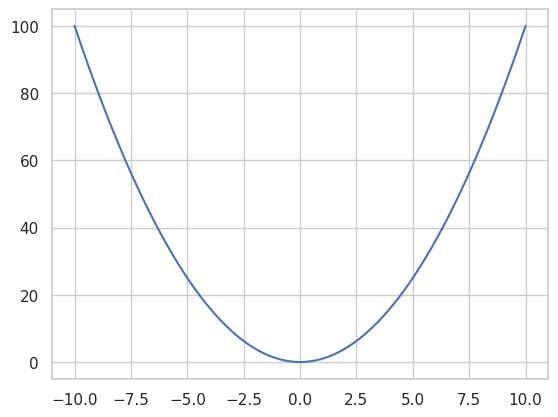

In [81]:
x = np.linspace(-10, 10, 1_000)
y = x**2

plt.plot(x, y)
plt.show()

Реальные данные обычно содержат шум. Для их отображения часто используют диаграммы рассеяния (_scatter plot_):

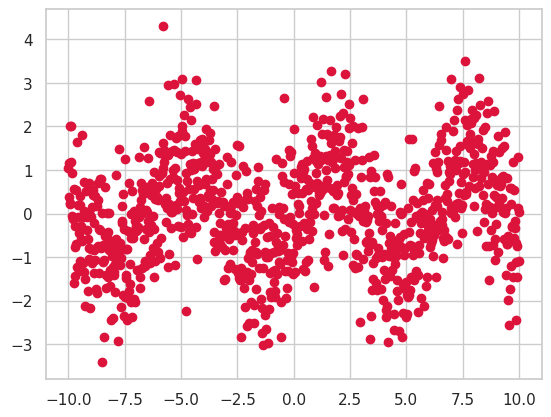

In [82]:
x = np.linspace(-10, 10, 1_000)
y = np.sin(x) + np.random.normal(size=x.size)

plt.scatter(x, y, color="crimson")
plt.show()

Уже неплохо, но до _publication quality_ еще далеко. Добавим заголовок, легенду и подписи осей:

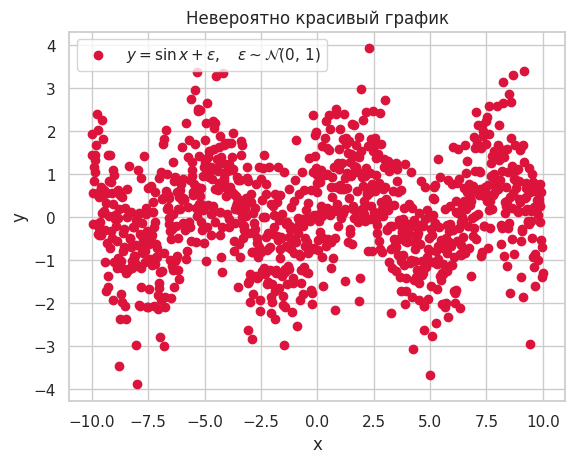

In [83]:
y = np.sin(x) + np.random.normal(size=x.size)
x = np.linspace(-10, 10, 1_000)

plt.scatter(x, y, color="crimson", label=r"$ y = \sin x + \epsilon,\quad \epsilon \sim \mathcal{N}(0,\,1) $")

plt.xlabel("x")
plt.ylabel("y")

plt.title("Невероятно красивый график")

plt.legend()

plt.savefig("awesome_plot.png", dpi=200, bbox_inches="tight")
plt.show()

Чтобы отобразить распределение одного числового признака, используют гистограммы. Для их построения служит функция `plt.hist`:

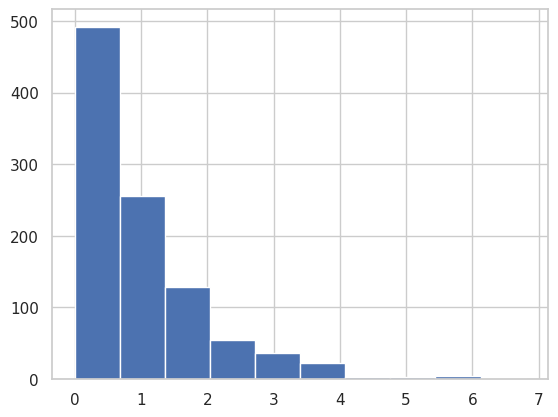

In [84]:
x = np.random.exponential(size=1_000)

plt.hist(x)
plt.show()

Чтобы отобразить распределение некоторого значения по категориям, можно использовать столбчатые диаграммы (_bar plot_) или круговые диаграммы (_pie chart_). Заодно посмотрим, как изобразить несколько графиков вместе:

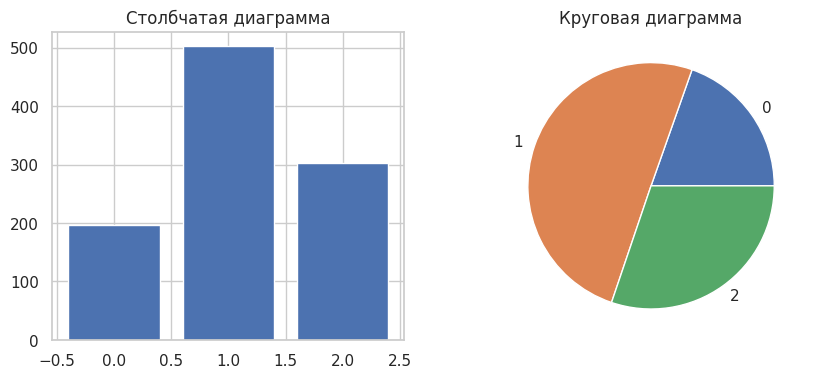

In [86]:
fig, axs = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(10, 4)

x = np.random.choice(range(3), size=1_000, replace=True, p=(0.2, 0.5, 0.3))
values, counts = np.unique(x, return_counts=True)

axs[0].bar(x=values, height=counts)
axs[0].set_title("Столбчатая диаграмма")

axs[1].pie(counts, labels=values)
axs[1].set_title("Круговая диаграмма")

plt.show()

Теперь поработаем с реальными данными. Сегодня у нас в гостях пингвины с архипелага Палмер (современная альтернатива ирисам Фишера). Датасет содержит информацию о трех видах пингвинов: _Chinstrap_, _Gentoo_ и _Adelie_. Artwork by @allison_horst

![image](https://github.com/allisonhorst/palmerpenguins/raw/main/man/figures/lter_penguins.png)

In [87]:
penguins = pd.read_csv("penguins.csv")
print(f"{penguins.shape = }")
penguins.head()

penguins.shape = (344, 8)


,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,male,2007
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007


В датасете представлены следующие признаки:

- _species_ — вид пингвина
- _island_ — остров архипелага Палмер, где был найден пингвин  
- _bill_length_mm_ — длина клюва (в миллиметрах)  
- _bill_depth_mm_ — глубина (высота) клюва (в миллиметрах)  
- _flipper_length_mm_ — длина ластов (в миллиметрах)  
- _body_mass_g_ — масса тела (в граммах)  
- _sex_ — пол пингвина  


![image](https://github.com/allisonhorst/palmerpenguins/raw/main/man/figures/culmen_depth.png)

Для простоты избавимся от пропущенных значений:

In [88]:
penguins.isna().sum()

species               0
island                0
bill_length_mm        2
bill_depth_mm         2
flipper_length_mm     2
body_mass_g           2
sex                  11
year                  0
dtype: int64

In [89]:
penguins = penguins.dropna()

В прошлый раз мы узнали, что в Pandas есть встроенные инструменты для визуализации данных:

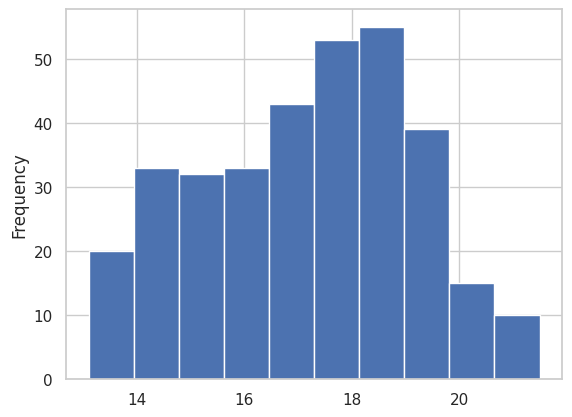

In [90]:
penguins["bill_depth_mm"].plot.hist()
plt.show()

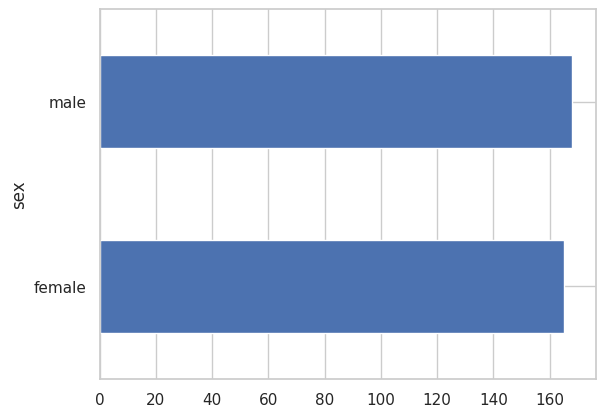

In [91]:
penguins.groupby("sex").size().plot.barh()
plt.show()

На практике для работы с `pd.DataFrame` и статистической визуализации данных удобно использовать библиотеку [Seaborn](https://seaborn.pydata.org/), она основана на Matplotlib и существенно расширяет возможности последней.

Мы уже импортировали Seaborn под именем `sns`. Для самых любопытных: название `sns` — это отсылка к сериалу «Западное крыло», повествующему о буднях администрации Президента США. SNS — это инициалы одного из персонажей, Samuel Norman Seaborn.

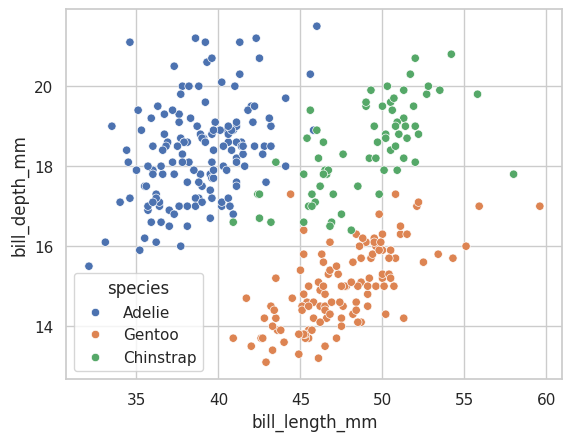

In [96]:
sns.scatterplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")
plt.show()

Еще один тип визуализации — это ящик с усами (_box plot_). Центральная линия показывает медиану, края прямоугольника соответствуют первому и третьему квартилям (Q1 и Q3), а расстояние между ними называется межквартильным размахом (IQR). Усы обычно обозначают значения Q1 − 1.5 · IQR и Q3 + 1.5 · IQR, а отдельные точки за пределами этого диапазона считаются выбросами.


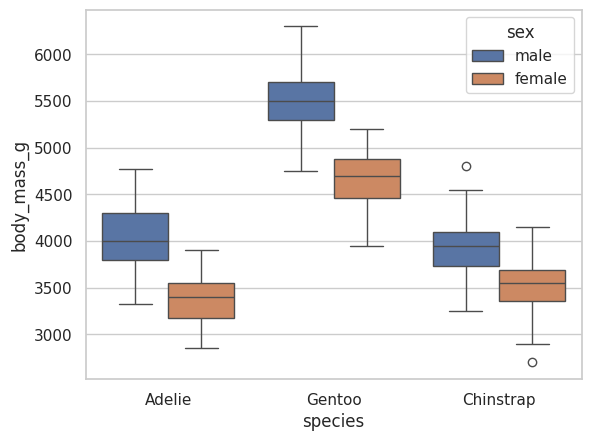

In [97]:
sns.boxplot(data=penguins, x="species", y="body_mass_g", hue="sex")
plt.show()

Изобразить распределение данных можно также при помощи скрипичной диаграммы (_violin plot_). Она очень похожа на _box plot_, но дополнительно показывает оценку плотности распределения точек:

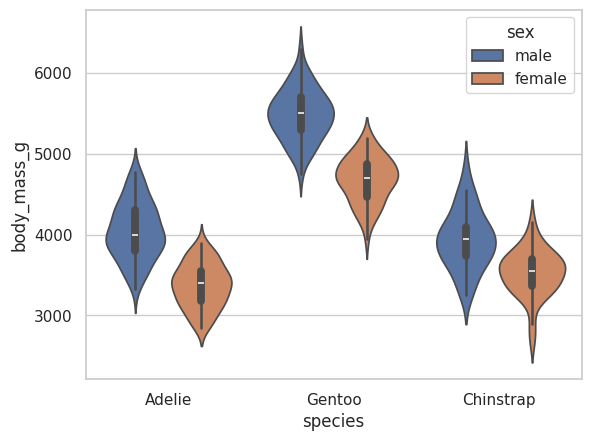

In [98]:
sns.violinplot(data=penguins, x="species", y="body_mass_g", hue="sex")
plt.show()

Напоследок один приятный бонус от Seaborn. Чтобы быстро ознакомиться с совместным распределением данных, можно использовать функцию `sns.pairplot`:

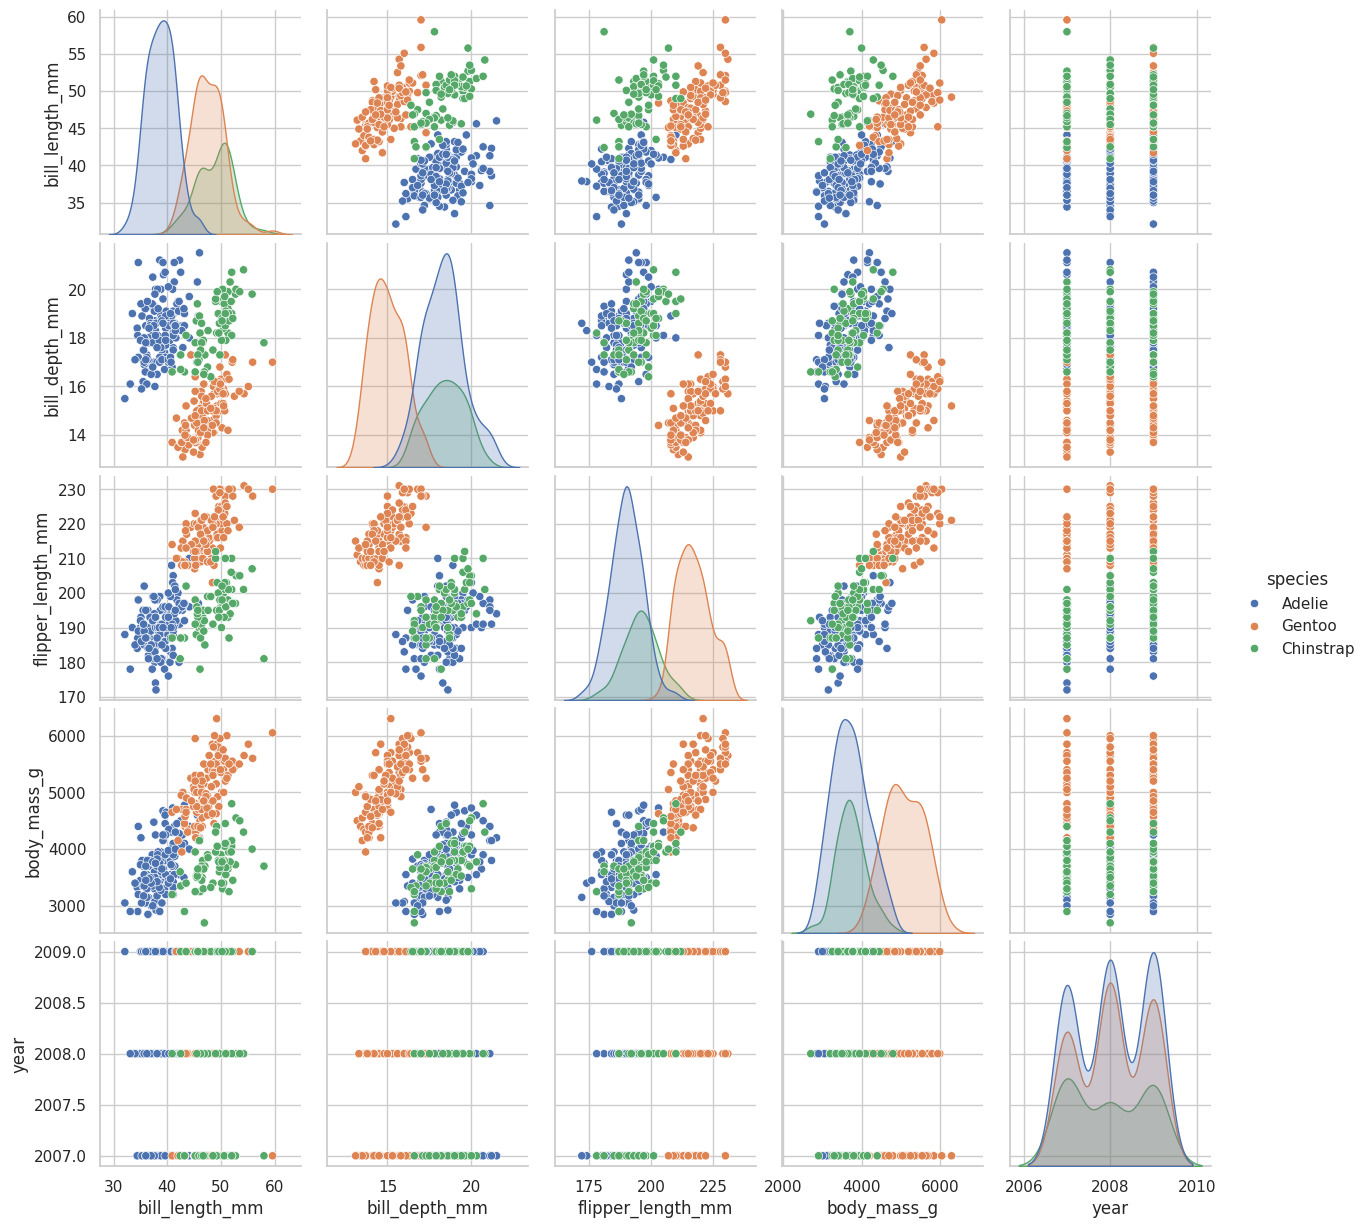

In [99]:
sns.pairplot(penguins, hue="species")
plt.show()

На минутку отвлечемся от наших данных. Еще один крайне полезный инструмент для визуализации — это тепловая карта (_heatmap_):

<Axes: xlabel='Task', ylabel='Model'>

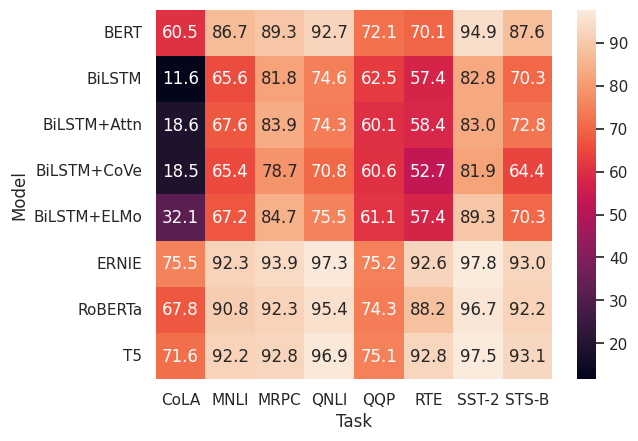

In [101]:
glue = sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
sns.heatmap(glue, annot=True, fmt=".1f")

## Описательная статистика

### Меры центральной тенденции. Медиана, выборочное среднее, мода

Основными мерами центральной тенденции являются выборочное среднее, медиана (она же 0.5-квантиль, 50-й перцентиль и 2-й квартиль) и мода.

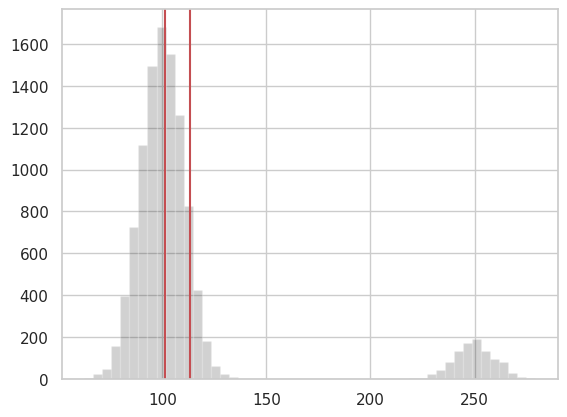

In [112]:
x = np.concat(
    (
        np.random.normal(loc=100, scale=10, size=10_000),
        np.random.normal(loc=250, scale=10, size=1_000),
    )
)

plt.hist(x, bins=50, color="k", alpha=0.2)

plt.axvline(np.mean(x), color="r")
plt.axvline(np.median(x), color="r")

# plt.axvline(np.mean(x), color="r", label="mean")
# plt.axvline(np.median(x), color="g", label="median")

plt.show()

### Меры изменчивости. Дисперсия и стандартное отклонение

<Axes: ylabel='Count'>

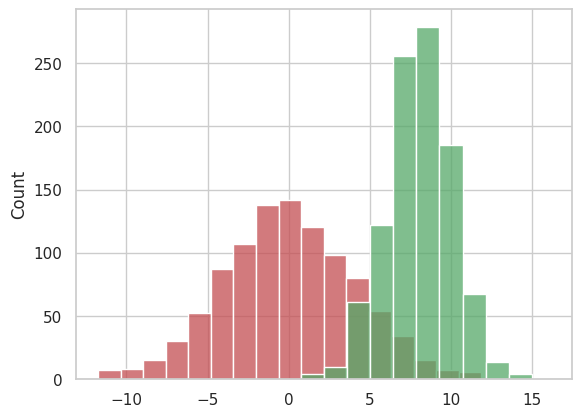

In [113]:
x1 = np.random.normal(loc=0.0, scale=4.0, size=1_000)
x2 = np.random.normal(loc=8.0, scale=2.0, size=1_000)

sns.histplot(x1, color="r", bins=20)
sns.histplot(x2, color="g", bins=10)

In [ ]:
x1.var(), x2.var()

(np.float64(15.772271444611597), np.float64(3.824335389942594))

In [ ]:
x1.std(), x2.std()

(np.float64(3.971431913631606), np.float64(1.955590803297713))

### Квантили, квартили и перцентили. IQR

<Axes: xlabel='bill_depth_mm', ylabel='Proportion'>

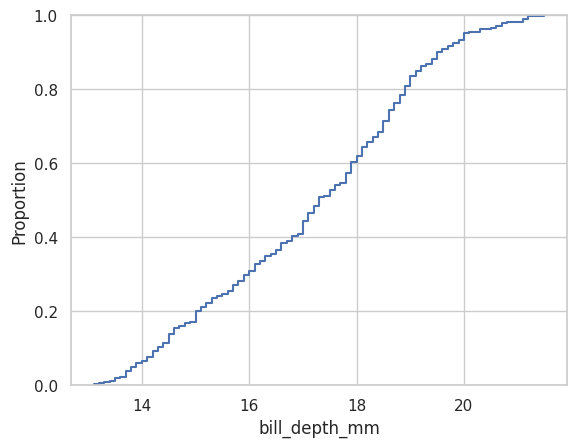

In [28]:
sns.ecdfplot(penguins, x="bill_depth_mm")

In [29]:
penguins["bill_depth_mm"].describe()

count    333.000000
mean      17.164865
std        1.969235
min       13.100000
25%       15.600000
50%       17.300000
75%       18.700000
max       21.500000
Name: bill_depth_mm, dtype: float64

In [30]:
penguins["bill_depth_mm"].quantile((0.25, 0.5, 0.75))

0.25    15.6
0.50    17.3
0.75    18.7
Name: bill_depth_mm, dtype: float64

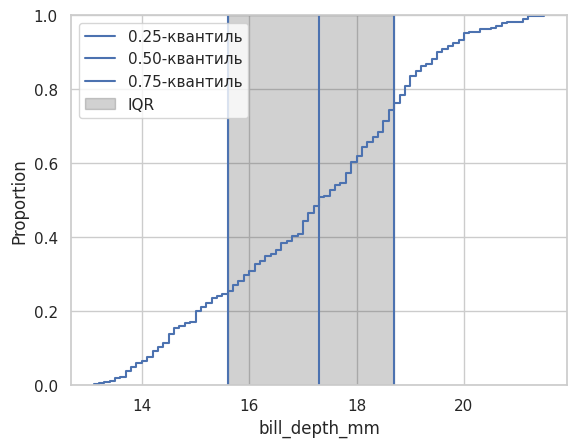

In [31]:
sns.ecdfplot(penguins, x="bill_depth_mm")

quantiles = penguins["bill_depth_mm"].quantile((0.25, 0.5, 0.75))

for label, value in quantiles.items():
    plt.axvline(value, label=f"{label:.2f}-квантиль")

plt.axvspan(quantiles[0.25], quantiles[0.75], color="k", alpha=0.2, label="IQR")

plt.legend()

### Центральная предельная теорема

Центральная предельная теорема (ЦПТ) является одним из важнейших инструментов статистического анализа. Пусть $X_1, X_2, \ldots, X_n$ — независимые и одинаково распределенные случайные величины с математическим ожиданием $\mathbb{E}[X_i] = \mu < \infty$ и дисперсией $0 < \mathrm{Var}(X_i) = \sigma^2 < \infty$. Тогда случайная величина  

$$
Z_n = \frac{\overline{X} - \mu}{\sigma / \sqrt{n}} 
$$

сходится по распределению к стандартной нормальной случайной величине при $n \to \infty$. Важная особенность ЦПТ состоит в том, что для нас не имеет значения, какое распределение имеют случайные величины $X_i$.

На практике это означает, что если мы будем сэмплировать подвыборки для расчета среднего из генеральной совокупности со средним значением $ \mu $ и дисперсией $ \sigma^2 $, то распределение выборочных средних будет стремиться к нормальному распределению со средним $ \mu $ и стандартным отклонением $ \sigma / \sqrt{n} $.  

Давайте это проверим.

In [116]:
adelie_female = penguins[(penguins["species"] == "Adelie") & (penguins["sex"] == "female")]
adelie_female

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,year
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,female,2007
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,female,2007
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,female,2007
6,Adelie,Torgersen,38.9,17.8,181.0,3625.0,female,2007
12,Adelie,Torgersen,41.1,17.6,182.0,3200.0,female,2007
...,...,...,...,...,...,...,...,...
142,Adelie,Dream,32.1,15.5,188.0,3050.0,female,2009
144,Adelie,Dream,37.3,16.8,192.0,3000.0,female,2009
147,Adelie,Dream,36.6,18.4,184.0,3475.0,female,2009
148,Adelie,Dream,36.0,17.8,195.0,3450.0,female,2009


<Axes: xlabel='body_mass_g', ylabel='Count'>

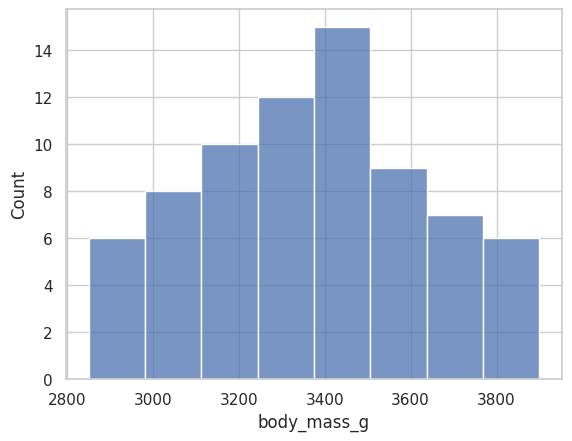

In [117]:
sns.histplot(adelie_female["body_mass_g"])

In [120]:
# Среднее значение генеральной совокупности
adelie_female["body_mass_g"].mean().round()

np.float64(3369.0)

In [121]:
# Выборочное среднее
adelie_female["body_mass_g"].loc[[54, 64, 116]].mean().round()

np.float64(2883.0)

<Axes: ylabel='Count'>

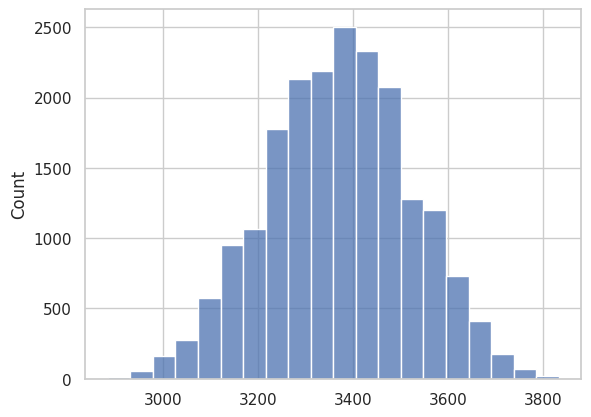

In [139]:
sample_mean_values = []

for _ in range(20_000):
    sample_mean_values.append(adelie_female["body_mass_g"].sample(3).mean())

sns.histplot(sample_mean_values, bins=20)

In [140]:
sample_mean_values = np.stack(sample_mean_values)

In [141]:
# Среднее выборочных средних
sample_mean_values.mean()

np.float64(3369.865)

In [142]:
# Стандартное отклонение выборочных средних
sample_mean_values.std()

np.float64(152.36888661512668)

In [143]:
adelie_female["body_mass_g"].std() / 3**0.5

np.float64(155.52667431387923)

### Ковариация и корреляция

<Axes: xlabel='body_mass_g', ylabel='flipper_length_mm'>

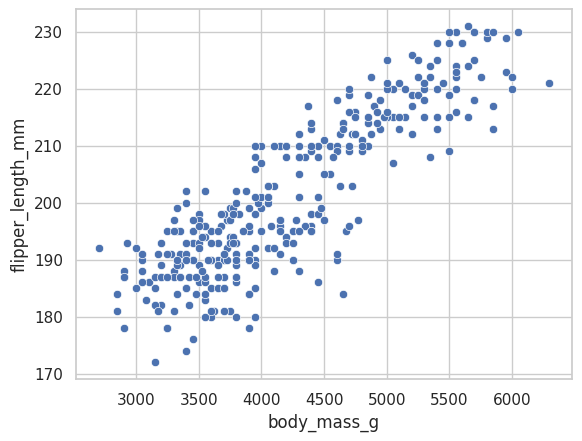

In [35]:
sns.scatterplot(data=penguins, x="body_mass_g", y="flipper_length_mm")

In [36]:
penguins[["body_mass_g", "flipper_length_mm"]].cov()

,body_mass_g,flipper_length_mm
body_mass_g,648372.487699,9852.191649
flipper_length_mm,9852.191649,196.441677


In [37]:
penguins[["body_mass_g", "flipper_length_mm"]].corr(method="spearman")

,body_mass_g,flipper_length_mm
body_mass_g,1.00000,0.84039
flipper_length_mm,0.84039,1.00000


In [38]:
stats.pearsonr(penguins["body_mass_g"], penguins["flipper_length_mm"])

PearsonRResult(statistic=np.float64(0.8729788985653616), pvalue=np.float64(3.1328362509712445e-105))

In [39]:
stats.spearmanr(penguins["body_mass_g"], penguins["flipper_length_mm"])

SignificanceResult(statistic=np.float64(0.8403902050259514), pvalue=np.float64(4.630423990534208e-90))

## Проверка гипотез

### Критерий согласия Пирсона ($ \chi^{2} $)

Проверим гипотезу о том, что распределение видов пингвинов не зависит от острова:

In [169]:
observed = pd.crosstab(penguins["island"], penguins["species"])
observed

species,Adelie,Chinstrap,Gentoo
island,,,
Biscoe,44,0,119
Dream,55,68,0
Torgersen,47,0,0


In [170]:
stats.chi2_contingency(observed)

Chi2ContingencyResult(statistic=np.float64(284.5900126880923), pvalue=np.float64(2.2818915409873682e-60), dof=4, expected_freq=array([[71.46546547, 33.28528529, 58.24924925],
       [53.92792793, 25.11711712, 43.95495495],
       [20.60660661,  9.5975976 , 16.7957958 ]]))

### Сравнение выборочных средних. t-критерий Стьюдента

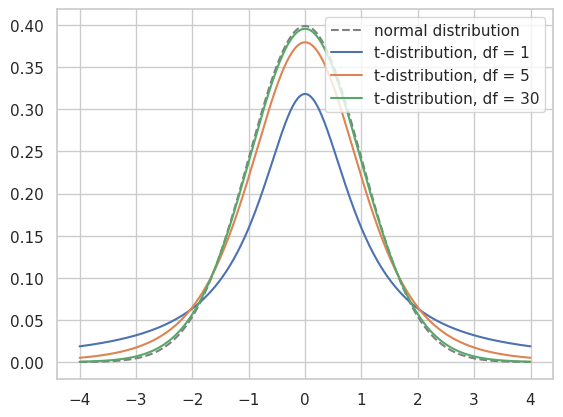

In [171]:
x = np.linspace(-4, 4, 1000)

plt.plot(x, stats.norm.pdf(x), label="normal distribution", color="gray", linestyle="--")

for df in (1, 5, 30):
    plt.plot(x, stats.t.pdf(x, df), label=f"t-distribution, df = {df}")

plt.legend()
plt.show()

Проверим гипотезу о равенстве среднего веса пингвинов Adelie ($\mu_1$) и Gentoo ($\mu_2$):

$H_0: \mu_1 = \mu_2$  
$H_1: \mu_1 \neq \mu_2$  

In [172]:
stats.ttest_ind(
    penguins[penguins["species"] == "Adelie"]["body_mass_g"], penguins[penguins["species"] == "Gentoo"]["body_mass_g"]
)

TtestResult(statistic=np.float64(-23.466803147391744), pvalue=np.float64(1.8806652580952688e-66), df=np.float64(263.0))

Полученное значение $p$-value < 0.05, то есть у нас есть достаточные основания, чтобы отклонить нулевую гипотезу $H_0$.  

### Дисперсионный анализ (Analysis of Variance, ANOVA)

Если мы хотим понять, отличаются ли средние значения в нескольких группах, можно использовать ANOVA:

In [207]:
groups = penguins.groupby("species")["body_mass_g"]

samples = [group.values for _, group in groups]
# samples

In [208]:
stats.f_oneway(*samples)

F_onewayResult(statistic=np.float64(341.8948949481461), pvalue=np.float64(3.74450512630046e-81))

In [209]:
model = ols("body_mass_g ~ species", penguins).fit()
sm.stats.anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
species,2.0,1.451902e+08,7.259511e+07,341.894895,3.744505e-81
Residual,330.0,7.006945e+07,2.123317e+05,NaN,NaN


Хорошо, теперь мы знаем, что выборочные средние в группах отличаются, но как понять, в каких именно? Один из самых популярных вариантов — использовать критерий Тьюки:

In [213]:
tukey = pairwise_tukeyhsd(penguins["body_mass_g"], penguins["species"])
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
Adelie,Chinstrap,26.9239,0.9164,-132.3528,186.2005,False
Adelie,Gentoo,1386.2726,0.0,1252.2897,1520.2554,True
Chinstrap,Gentoo,1359.3487,0.0,1194.4304,1524.2671,True


<Axes: xlabel='species', ylabel='body_mass_g'>

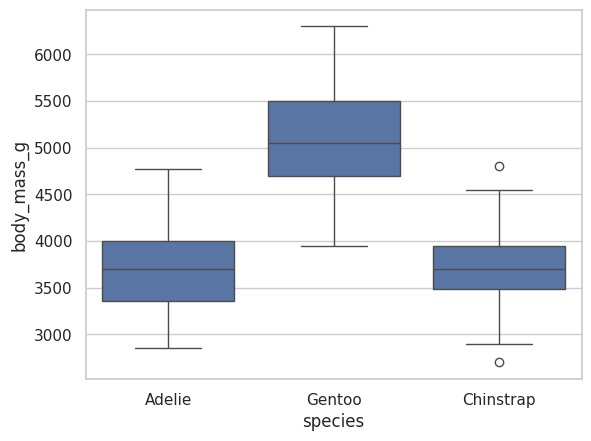

In [214]:
sns.boxplot(data=penguins, x="species", y="body_mass_g")

## Множественное тестирование гипотез

А зачем вообще нужно проводить ANOVA? Почему нельзя просто провести несколько парных t-тестов? Давайте рассмотрим пример:

In [202]:
def run_t_tests(n_samples: int, sample_size: int, alpha: float = 0.05, n_experiments: int = 5000) -> float:
    n_significant_experiments = 0

    for _ in range(n_experiments):
        found_significant = False
        data = np.random.normal(loc=0, scale=1, size=(n_samples, sample_size))

        for i in range(n_samples):
            if found_significant:
                break

            for j in range(i + 1, n_samples):
                _, pvalue = stats.ttest_ind(data[i], data[j])

                if pvalue < alpha:
                    n_significant_experiments += 1
                    found_significant = True
                    break

    return n_significant_experiments / n_experiments

In [203]:
run_t_tests(2, 25)

0.0518

При сравнении двух групп, как и ожидалось, мы получили примерно 0.05 ложноположительных результатов (напомним, что данные взяты из одного распределения). Но что будет, если увеличить количество групп, например, до 10?

In [204]:
run_t_tests(10, 25)

0.631

О, ужас, доля ложноположительных уже превысила 0.5! Для решения этой проблемы используют поправки на множественные сравнения. Самая простая и понятная — поправка Бонферрони. Если мы проводим $N$ сравнений, то давайте использовать уровень значимости $\alpha / N$.

In [206]:
n_samples = 10
n_comparisons = n_samples * (n_samples - 1) / 2

run_t_tests(n_samples, 25, alpha=0.05 / n_comparisons)

0.0372